# MNIST handwritten digits classification with MLPs

In this notebook, we'll train a multi-layer perceptron model to classify MNIST digits using [TensorFlow](https://www.tensorflow.org/) (version $\ge$ 2.0 required) with the [Keras API](https://www.tensorflow.org/guide/keras/overview).

First, the needed imports.

In [1]:
%matplotlib inline

import os
if not os.path.isfile('pml_utils.py'):
  !wget https://raw.githubusercontent.com/csc-training/intro-to-dl/master/day1/pml_utils.py
from pml_utils import show_failures

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model, to_categorical

from distutils.version import LooseVersion as LV

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

print('Using Tensorflow version: {}, and Keras version: {}.'.format(tf.__version__, tf.keras.__version__))
assert(LV(tf.__version__) >= LV("2.0.0"))

Using Tensorflow version: 2.3.0, and Keras version: 2.4.0.


Let's check if we have GPU available.

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) > 0:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    from tensorflow.python.client import device_lib
    for d in device_lib.list_local_devices():
        if d.device_type == 'GPU':
            print('GPU', d.physical_device_desc)
else:
    print('No GPU, using CPU instead.')

No GPU, using CPU instead.


## MNIST data set

Next we'll load the MNIST handwritten digits data set using TensorFlow's own tools.  First time we may have to download the data, which can take a while.

#### Altenative: Fashion-MNIST

Alternatively, MNIST can be replaced with Fashion-MNIST, which can be used as drop-in replacement for MNIST.   Fashion-MNIST contains images of 10 fashion categories:

Label|Description|Label|Description
--- | --- |--- | ---
0|T-shirt/top|5|Sandal
1|Trouser|6|Shirt
2|Pullover|7|Sneaker
3|Dress|8|Bag
4|Coat|9|Ankle boot


In [3]:
from tensorflow.keras.datasets import mnist, fashion_mnist

## MNIST:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
## Fashion-MNIST:
#(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

nb_classes = 10

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

# one-hot encoding:
Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

print()
print('MNIST data loaded: train:',len(X_train),'test:',len(X_test))
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('Y_train:', Y_train.shape)

4423680/4422102 [==============================] - 0s 0us/step

MNIST data loaded: train: 60000 test: 10000
X_train: (60000, 28, 28)
y_train: (60000,)
Y_train: (60000, 10)


The training data (`X_train`) is a 3rd-order tensor of size (60000, 28, 28), i.e. it consists of 60000 images of size 28x28 pixels. `y_train` is a 60000-dimensional vector containing the correct classes ("0", "1", ..., "9") for each training sample, and `Y_train` is a [one-hot](https://en.wikipedia.org/wiki/One-hot) encoding of `y_train`.

Let's take a closer look. Here are the first 10 training digits (or fashion items for Fashion-MNIST):

Training sample 0 : class: 9 , one-hot encoded: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Training sample 1 : class: 0 , one-hot encoded: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Training sample 2 : class: 0 , one-hot encoded: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Training sample 3 : class: 3 , one-hot encoded: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Training sample 4 : class: 0 , one-hot encoded: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Training sample 5 : class: 2 , one-hot encoded: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Training sample 6 : class: 7 , one-hot encoded: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Training sample 7 : class: 2 , one-hot encoded: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Training sample 8 : class: 5 , one-hot encoded: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Training sample 9 : class: 5 , one-hot encoded: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


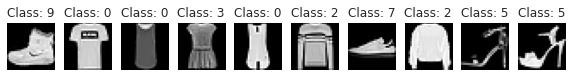

In [4]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:], cmap="gray")
    plt.title('Class: '+str(y_train[i]))
    print('Training sample',i,': class:',y_train[i], ', one-hot encoded:', Y_train[i])

## Multi-layer perceptron (MLP) network

Let's create an MLP model that has multiple layers, non-linear activation functions, and optionally dropout layers for regularization.

### Initialization

We first create the `Input` of shape 28x28 to match the size of the input data. Then we use a `Flatten` layer to convert the 2D image data into vectors of size 784.

We add a `Dense` layer that has 20 output nodes. The `Dense` layer connects each input to each output with some weight parameter and then passes the result through a ReLU non-linear activation function.

The output of the last layer needs to be a softmaxed 10-dimensional vector to match the ground truth (`Y_train`).  This means that it will output 10 values between 0 and 1 which sum to 1, hence, together they can be interpreted as a probability distribution over our 10 classes.

After all layers are created, we create the `Model` by specifying its inputs and outputs.

Finally, we select *categorical crossentropy* as the loss function, select [*adam*](https://keras.io/api/optimizers/adam/) as the optimizer, add *accuracy* to the list of metrics to be evaluated, and `compile()` the model.  Adam is simply a an advanced version of stochastic gradient descent, note there are [several different options](https://keras.io/optimizers/) for the optimizer in Keras that we could use instead of *adam*.

In [5]:
# Model initialization:
inputs = keras.Input(shape=(28, 28))
x = layers.Flatten()(inputs)

# A simple model:
x = layers.Dense(units=20, activation="relu")(x)

# The last layer needs to be like this:
outputs = layers.Dense(units=10, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs,
                    name="mlp_model")
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
print(model.summary())

Model: "mlp_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                15700     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
_________________________________________________________________
None


The summary shows that there are 15,910 parameters in total in our model.

For example for the first dense layer we have 785x20 = 15,700 parameters as the weight matrix is of size 785x20 (not 784, as there's an additional bias term).

We can also draw a fancier graph of our model.

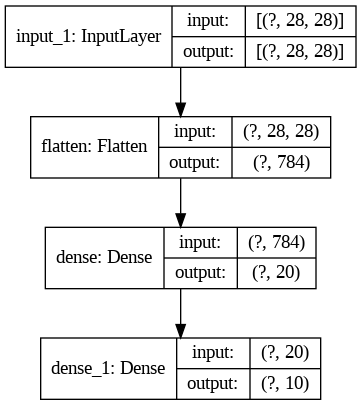

In [6]:
plot_model(model, show_shapes=True)

### Learning

Next, we'll train our model.  Notice how the interface is similar to scikit-learn: we still call the `fit()` method on our model object.

An *epoch* means one pass through the whole training data, we'll begin by running training for 10 epochs.

You can run code below multiple times and it will continue the training process from where it left off.  If you want to start from scratch, re-initialize the model using the code a few cells ago. 

We use a batch size of 32, so the actual input will be 32x784 for each batch of 32 images.

In [7]:
%%time
epochs = 10

history = model.fit(X_train, Y_train, 
                    epochs=epochs, 
                    batch_size=32,
                    verbose=2)

Epoch 1/10
1875/1875 - 4s - loss: 0.5863 - accuracy: 0.7998
Epoch 2/10
1875/1875 - 4s - loss: 0.4358 - accuracy: 0.8486
Epoch 3/10
1875/1875 - 4s - loss: 0.4063 - accuracy: 0.8576
Epoch 4/10
1875/1875 - 4s - loss: 0.3902 - accuracy: 0.8623
Epoch 5/10
1875/1875 - 3s - loss: 0.3752 - accuracy: 0.8675
Epoch 6/10
1875/1875 - 4s - loss: 0.3643 - accuracy: 0.8712
Epoch 7/10
1875/1875 - 4s - loss: 0.3550 - accuracy: 0.8748
Epoch 8/10
1875/1875 - 4s - loss: 0.3490 - accuracy: 0.8768
Epoch 9/10
1875/1875 - 4s - loss: 0.3431 - accuracy: 0.8783
Epoch 10/10
1875/1875 - 4s - loss: 0.3358 - accuracy: 0.8807
CPU times: user 54.6 s, sys: 21.4 s, total: 1min 15s
Wall time: 40.3 s


Let's now see how the training progressed. 

* *Loss* is a function of the difference of the network output and the target values.  We are minimizing the loss function during training so it should decrease over time.
* *Accuracy* is the classification accuracy for the training data.  It gives some indication of the real accuracy of the model but cannot be fully trusted, as it may have overfitted and just memorizes the training data.

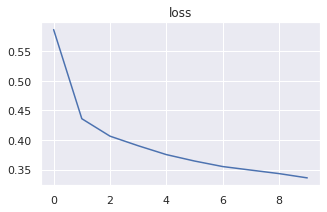

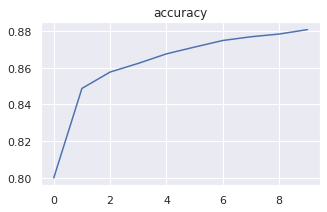

In [8]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

### Inference

For a better measure of the quality of the model, let's see the model accuracy for the test data. 

In [9]:
%%time
scores = model.evaluate(X_test, Y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

313/313 - 0s - loss: 0.4211 - accuracy: 0.8457
accuracy: 84.57%
CPU times: user 736 ms, sys: 330 ms, total: 1.07 s
Wall time: 712 ms


We can now take a closer look at the results using the `show_failures()` helper function.

Here are the first 10 test digits the MLP classified to a wrong class:

Showing max 10 first failures. The predicted class is shown first and the correct class in parenthesis.


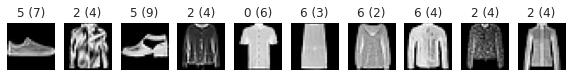

In [10]:
predictions = model.predict(X_test)

show_failures(predictions, y_test, X_test)

We can use `show_failures()` to inspect failures in more detail. For example, here are failures in which the true class was "6":

Showing max 10 first failures. The predicted class is shown first and the correct class in parenthesis.


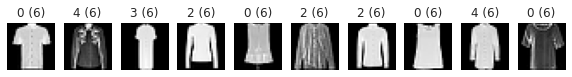

In [11]:
show_failures(predictions, y_test, X_test, trueclass=6)

We can also compute the confusion matrix to see which digits get mixed the most, and look at classification accuracies separately for each class:

In [12]:
from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
cm=confusion_matrix(y_test, np.argmax(predictions, axis=1), labels=list(range(10)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.sum(axis=1)): print("%d: %.4f" % (i,j))

Confusion matrix (rows: true classes; columns: predicted classes):

[[766   2  13  32   2   3 175   0   7   0]
 [  3 967   2  19   2   0   7   0   0   0]
 [ 17   1 819  10  42   0 109   0   2   0]
 [ 39  24  19 846  20   0  51   0   1   0]
 [  2   1 206  41 612   0 134   0   4   0]
 [  0   0   0   2   0 949   0  23   2  24]
 [128   3 104  23  44   0 688   0  10   0]
 [  0   0   0   0   0  36   0 921   0  43]
 [  7   0   4  11   2   2  36   7 931   0]
 [  0   0   0   0   0  11   1  30   0 958]]

Classification accuracy for each class:

0: 0.7660
1: 0.9670
2: 0.8190
3: 0.8460
4: 0.6120
5: 0.9490
6: 0.6880
7: 0.9210
8: 0.9310
9: 0.9580


## Task 1: Model with two dense layers

Your task is to try the same problem as above, but with a more complex model. The new model should have **two dense layers**, each with:

- 50 units
- ReLU activation
- each followed by a dropout layer with a rate of 0.2

Dropout randomly sets a fraction of inputs to zero during training, which is one approach to regularization and can sometimes help to prevent overfitting.

You can consult the Keras documentation at https://keras.io/.  For example, the Dense, Activation, and Dropout layers are described at https://keras.io/layers/core/.

The code below is missing the model definition. You can copy any suitable layers from the example above.

In [13]:
ex1_inputs = keras.Input(shape=(28, 28))
x = layers.Flatten()(ex1_inputs)

x = layers.Dense(units=50,
                 activation="relu")(x)
x = layers.Dropout(rate=0.2)(x)

x = layers.Dense(units=50,
                 activation="relu")(x)
x = layers.Dropout(rate=0.2)(x)

#ex1_outputs = None
ex1_outputs = layers.Dense(units=10, activation='softmax')(x)

Execute cell to see the [example answer](https://raw.githubusercontent.com/csc-training/intro-to-dl/master/day1/solutions/tf2-mnist-mlp-example-answer.py). 
Note: in Google Colab you have to click and copy the answer manually.

In [14]:
# %load solutions/tf2-mnist-mlp-example-answer.py
ex1_inputs = keras.Input(shape=(28, 28))

x = layers.Flatten()(ex1_inputs)
x = layers.Dense(units=50, activation="relu")(x)
x = layers.Dropout(rate=0.2)(x)
x = layers.Dense(units=50, activation="relu")(x)
x = layers.Dropout(rate=0.2)(x)

ex1_outputs = layers.Dense(units=10, activation='softmax')(x)


In [15]:
assert ex1_outputs is not None, "You need to write the missing model definition"

ex1_model = keras.Model(inputs=ex1_inputs, outputs=ex1_outputs,
                        name="two_layer_mlp_model")
ex1_model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
print(ex1_model.summary())

Model: "two_layer_mlp_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                39250     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)        

In [16]:
%%time
ex1_epochs = 10
ex1_history = ex1_model.fit(X_train, Y_train, 
                            epochs=epochs, 
                            batch_size=32,
                            verbose=2)

Epoch 1/10
1875/1875 - 4s - loss: 0.6466 - accuracy: 0.7724
Epoch 2/10
1875/1875 - 4s - loss: 0.4734 - accuracy: 0.8302
Epoch 3/10
1875/1875 - 4s - loss: 0.4356 - accuracy: 0.8444
Epoch 4/10
1875/1875 - 4s - loss: 0.4096 - accuracy: 0.8519
Epoch 5/10
1875/1875 - 5s - loss: 0.3972 - accuracy: 0.8573
Epoch 6/10
1875/1875 - 5s - loss: 0.3850 - accuracy: 0.8618
Epoch 7/10
1875/1875 - 4s - loss: 0.3748 - accuracy: 0.8638
Epoch 8/10
1875/1875 - 4s - loss: 0.3689 - accuracy: 0.8657
Epoch 9/10
1875/1875 - 4s - loss: 0.3623 - accuracy: 0.8695
Epoch 10/10
1875/1875 - 5s - loss: 0.3555 - accuracy: 0.8705
CPU times: user 1min 13s, sys: 30.7 s, total: 1min 44s
Wall time: 43.3 s


Let's plot the data to see how the training progressed. A big gap between training and validation accuracies would suggest overfitting.

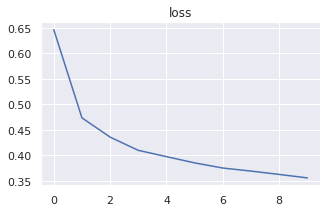

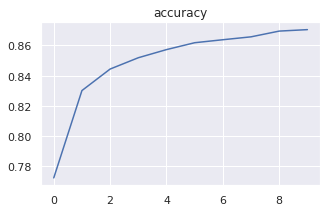

In [17]:
plt.figure(figsize=(5,3))
plt.plot(ex1_history.epoch, ex1_history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(ex1_history.epoch, ex1_history.history['accuracy'])
plt.title('accuracy');

In [18]:
ex1_scores = ex1_model.evaluate(X_test, Y_test, verbose=2)
print("%s: %.2f%%" % (ex1_model.metrics_names[1], ex1_scores[1]*100))

313/313 - 1s - loss: 0.3554 - accuracy: 0.8744
accuracy: 87.44%


## Task 2: Model tuning

Modify the MLP model.  Try to improve the classification accuracy, or experiment with the effects of different parameters.  If you are interested in the state-of-the-art performance on permutation invariant MNIST, see e.g. this [recent paper](https://arxiv.org/abs/1507.02672) by Aalto University / The Curious AI Company researchers.

You can also consult the Keras documentation at https://keras.io/.  For example, the Dense, Activation, and Dropout layers are described at https://keras.io/layers/core/.

<hr/>

*Run this notebook in Google Colaboratory using [this link](https://colab.research.google.com/github/csc-training/intro-to-dl/blob/master/day1/02-tf2-mnist-mlp.ipynb).*

Model: "two_layer_mlp_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                39250     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)        

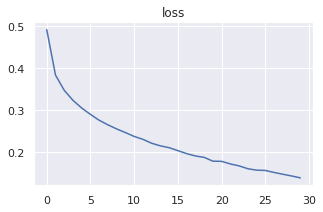

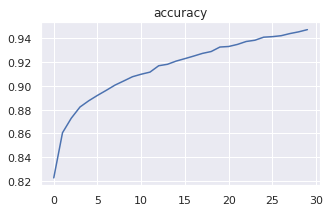

In [51]:
""" Model tuning
Model tuning
Note: I have tried to modify:
    - number of hidden layers: 2 | 3 | 4
    - units: 1 | 10 | 50 | 100
    - activation function: relu | sigmoid | softsign | tanh | selu
    - dropout rate: 0.1 | 0.2 | 0.5
    - number of epochs: 10 | 15 | 20
    - model optimizer: SGD | Adamax | Adadelta
"""

ex2_inputs = keras.Input(shape=(28, 28))
x = layers.Flatten()(ex2_inputs)

x = layers.Dense(units=100, activation="selu")(x)
x = layers.Dense(units=100, activation="selu")(x)

ex2_outputs = layers.Dense(units=10, activation='softmax')(x)

ex2_model = keras.Model(inputs=ex2_inputs, outputs=ex2_outputs,
                        name="custom_model")
ex2_model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

# Statistics

print(ex1_model.summary())

ex2_epochs = 30
ex2_history = ex2_model.fit(X_train, Y_train, epochs=ex2_epochs, batch_size=32, verbose=2)

plt.figure(figsize=(5,3))
plt.plot(ex2_history.epoch, ex2_history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(ex2_history.epoch, ex2_history.history['accuracy'])
plt.title('accuracy');

ex2_scores = ex2_model.evaluate(X_test, Y_test, verbose=2)
print("%s: %.2f%%" % (ex2_model.metrics_names[1], ex2_scores[1]*100))